# I - Classification de documents : prise en main des outils

Le but de ce TP est de classer des documents textuels... Dans un premier temps, nous allons vérifier le bon fonctionnement des outils sur des données jouets puis appliquer les concepts sur des données réelles.


## 1 - Conception de la chaine de traitement
Pour rappel, une chaine de traitement de documents classique est composée des étapes suivantes:
1. Lecture des données et importation
    - Dans le cadre de nos TP, nous faisons l'hypothèse que le corpus tient en mémoire... Si ce n'est pas le cas, il faut alors ajouter des structures de données avec des buffers (*data-reader*), bien plus complexes à mettre en place.
    - Le plus grand piège concerne l'encodage des données. Dans le TP... Pas (ou peu) de problème. Dans la vraie vie: il faut faire attention à toujours maitriser les formats d'entrée et de sortie.
1. Traitement des données brutes paramétrique. Chaque traitement doit être activable ou desactivable + paramétrable si besoin.
    - Enlever les informations *inutiles* : chiffre, ponctuations, majuscules, etc... <BR>
    **L'utilité dépend de l'application!**
    - Segmenter en mots (=*Tokenization*)
    - Elimination des stop-words
    - Stemming/lemmatisation (racinisation)
    - Byte-pair encoding pour trouver les mots composés (e.g. Sorbonne Université, Ville de Paris, Premier Ministre, etc...)
1. Traitement des données numériques
    - Normalisation *term-frequency* / binarisation
    - Normalisation *inverse document frequency*
    - Elimination des mots rares, des mots trop fréquents
    - Construction de critère de séparabilité pour éliminer des mots etc...
1. Apprentissage d'un classifieur
    - Choix du type de classifieur
    - Réglage des paramètres du classifieur (régularisation, etc...)

## 2 - Exploitation de la chaine de traitement

On appelle cette étape la réalisation d'une campagne d'expériences: c'est le point clé que nous voulons traviller en TAL cette année.
1. Il est impossible de tester toutes les combinaisons par rapport aux propositions ci-dessus... Il faut donc en éliminer un certain nombre.
    - En discutant avec les experts métiers
    - En faisant des tests préliminaires
1. Après ce premier filtrage, il faut:
    - Choisir une évaluation fiable et pas trop lente (validation croisée, leave-one-out, split apprentissage/test simple)
    - Lancer des expériences en grand
        - = *grid-search*
        - parallèliser sur plusieurs machines
        - savoir lancer sur un serveur et se déconnecter
1. Collecter et analyser les résultats


## 3 - Inférence

L'inférence est ensuite très classique: la chaine de traitement optimale est apte à traiter de nouveaux documents

# II - Chargement des données

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

import codecs
import re
import os.path

from sklearn.model_selection import train_test_split
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, cross_val_score

In [3]:
# Chargement des données:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs

#Mitterand correspond à la classe -1
#Chirac correspond à la classe 1


In [4]:
fname_train = "./ressources/AFDpresidentutf8/corpus.tache1.learn.utf8"
fname_test = "./ressources/AFDpresidentutf8/corpus.tache1.test.utf8"

x_train, y_train = load_pres(fname_train)
x_test, y_test = load_pres(fname_test)

#x représente les exemples
#y représente les classes
print(x_train[0], "\n est une phrase de ", [0, "Chirac", "Mitterand"][y_train[0]])

print("\nDimensions de notre espace d'entrainement: ", len(x_train),len(y_train))
print("\nDimensions de notre espace de test: ", len(x_test),len(y_test))

 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.
 
 est une phrase de  Chirac

Dimensions de notre espace d'entrainement:  57413 57413

Dimensions de notre espace de test:  27162 27162


# III - Transformation des données
## 1 - Transformation paramétrique du texte

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

[('de', 68579), ('', 57413), ('la', 39694), ('et', 34709), ('à', 26075), ('les', 24312), ('le', 24256), ('des', 21492), ('que', 15737), ('qui', 14808), ('en', 14197), ('pour', 11012), ('dans', 10957), ('du', 10638), ('un', 9237), ('une', 8900), ('nous', 7089), ('plus', 7078), ('au', 7067), ('est', 6981), ('vous', 6974), ('ce', 6439), ('a', 6303), ('je', 6014), ('pas', 5797), ('par', 5500), ('notre', 5214), ('ne', 5156), ('sur', 5111), ('nos', 4718), ('avec', 4583), ('se', 4488), ('sont', 4247), ('Je', 4149), ('aux', 4029), ('cette', 4009), ('aussi', 3787), ("c'est", 3676), ('il', 3647), ('leur', 3641), ('Il', 3639), ("C'est", 3455), ('France', 3442), ('ont', 3398), ('tout', 3250), ('votre', 3173), ('son', 3135), ('pays', 3126), ('La', 3088), ('<nom>', 3067)]


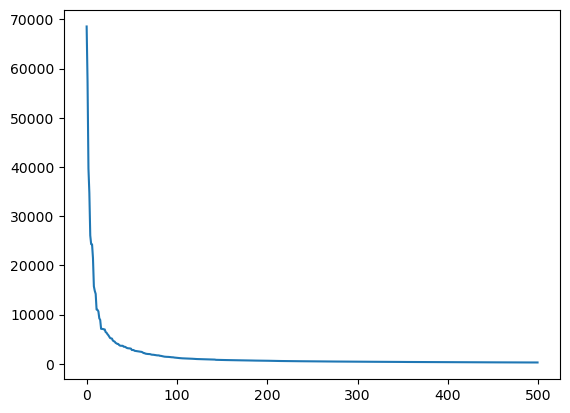

In [5]:
from collections import Counter

wc = Counter()
nb_max = 500

for text in x_train:
    wc.update(text.split(" ")) 
    
    #considère chaque mot comme étant des unités espacées par un " " 
    
freq = [f for w,f in wc.most_common()]
plt.plot(freq[:nb_max])

print(wc.most_common(50))

Parmi les mots les plus fréquents, on remarque qu'il y a beaucoup de "sur-information", inutile à la compréhension du texte: des majuscules ne changeant rien au mot, de la ponctuation etc... Par exemple, "la" et "La" apparaissent dans les mots les plus fréquents.

### 1.a) Retrait de la ponctuation

In [6]:
import string

punc = string.punctuation  
punc += '\n\r\t'

no_punc = x_train[0].translate(str.maketrans(punc, ' ' * len(punc)))  
print(x_train[0], "\n-->\n", no_punc)

 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.
 
-->
  Quand je dis chers amis  il ne s agit pas là d une formule diplomatique  mais de l expression de ce que je ressens  


### 1.b) Retrait des majuscules

In [7]:
import unicodedata

no_maj = unicodedata.normalize('NFD', x_train[0]).encode('ascii', 'ignore').decode("utf-8")
no_maj = no_maj.lower()
print(x_train[0], "\n-->\n", no_maj)

 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.
 
-->
  quand je dis chers amis, il ne s'agit pas la d'une formule diplomatique, mais de l'expression de ce que je ressens.



### 1.c) Fonction de pre-processing

Cette fonction combine les différentes modifications mises en avant précédemment. Nous allons appliquer ces modifications à l'ensemble d'apprentissage et de test.

In [8]:
def preprocess(x):
    new_list = [0]*len(x)
    i = 0
    for example in x:
        new_list[i] = unicodedata.normalize('NFD', example).encode('ascii', 'ignore').decode("utf-8").lower()
        new_list[i] = new_list[i].translate(str.maketrans(punc, ' ' * len(punc)))
        i += 1
    return new_list

x_train, x_test = preprocess(x_train), preprocess(x_test)

#-->transformation de nos exemples
print(x_train[2])

 c est toujours tres emouvant de venir en afrique car c est probablement l une des rares terres du monde ou l on ait conserve cette convivialite  cette amitie  ce respect de l autre qui s expriment avec chaleur  avec spontaneite et qui rechauffent le coeur de ceux qui arrivent et de ceux qui recoivent  


## 2 - Extraction du vocabulaire

Exploration préliminaire des jeux de données.

- Quelle est la taille d'origine du vocabulaire?
- Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
- Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
- Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
- Quelle est la distribution d'apparition des mots (Zipf)
- Quels sont les 100 bigrammes/trigrammes les plus fréquents?


### 2.a) Mots fréquents

/home/luca/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Il y a 27406 mots dans l'ensemble de training.
Il y a 20790 mots dans l'ensemble de test.


(-0.5, 399.5, 199.5, -0.5)

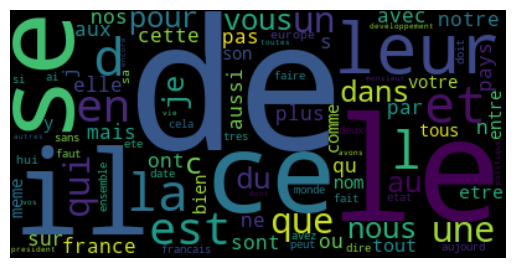

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

count = CountVectorizer()

Xcount_train = count.fit_transform(x_train)
print("Il y a " + str(len(count.get_feature_names())) + " mots dans l'ensemble de training.")

Xcount_test = count.fit_transform(x_test)
print("Il y a " + str(len(count.get_feature_names())) + " mots dans l'ensemble de test.")

#Il y a moins de mots que dans le cas non traité (sans pré-process).

#Nous recréons freq, la liste des fréquences, avec les exemples preprocess. On crée alors words_freq
#qui correspond à la liste des mots classés du plus fréquent au moins fréquent.

wc = Counter()

for text in x_train:
    wc.update(text.split(" ")) 
    
freq_train = [f for w,f in wc.most_common()]
words_train = [w for w,f in wc.most_common()]

freq_100 = freq_train[:100]
words_100 = words_train[:100]

words_100 = " ".join(words_100)
wordcloud = WordCloud().generate(words_100)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [10]:
wc = Counter()

for text in x_test:
    wc.update(text.split(" "))

freq_test = [f for w,f in wc.most_common()]
words_test = [w for w,f in wc.most_common()]

#Création de dictionnaires

freq_train_ = {}
freq_test_ = {}

for i in range(len(words_train)):
    freq_train_[words_train[i]] = freq_train[i]

for i in range(len(words_test)):
    freq_test_[words_test[i]] = freq_test[i]

print(freq_train_["de"])
print(freq_test_["de"])

69032
32219


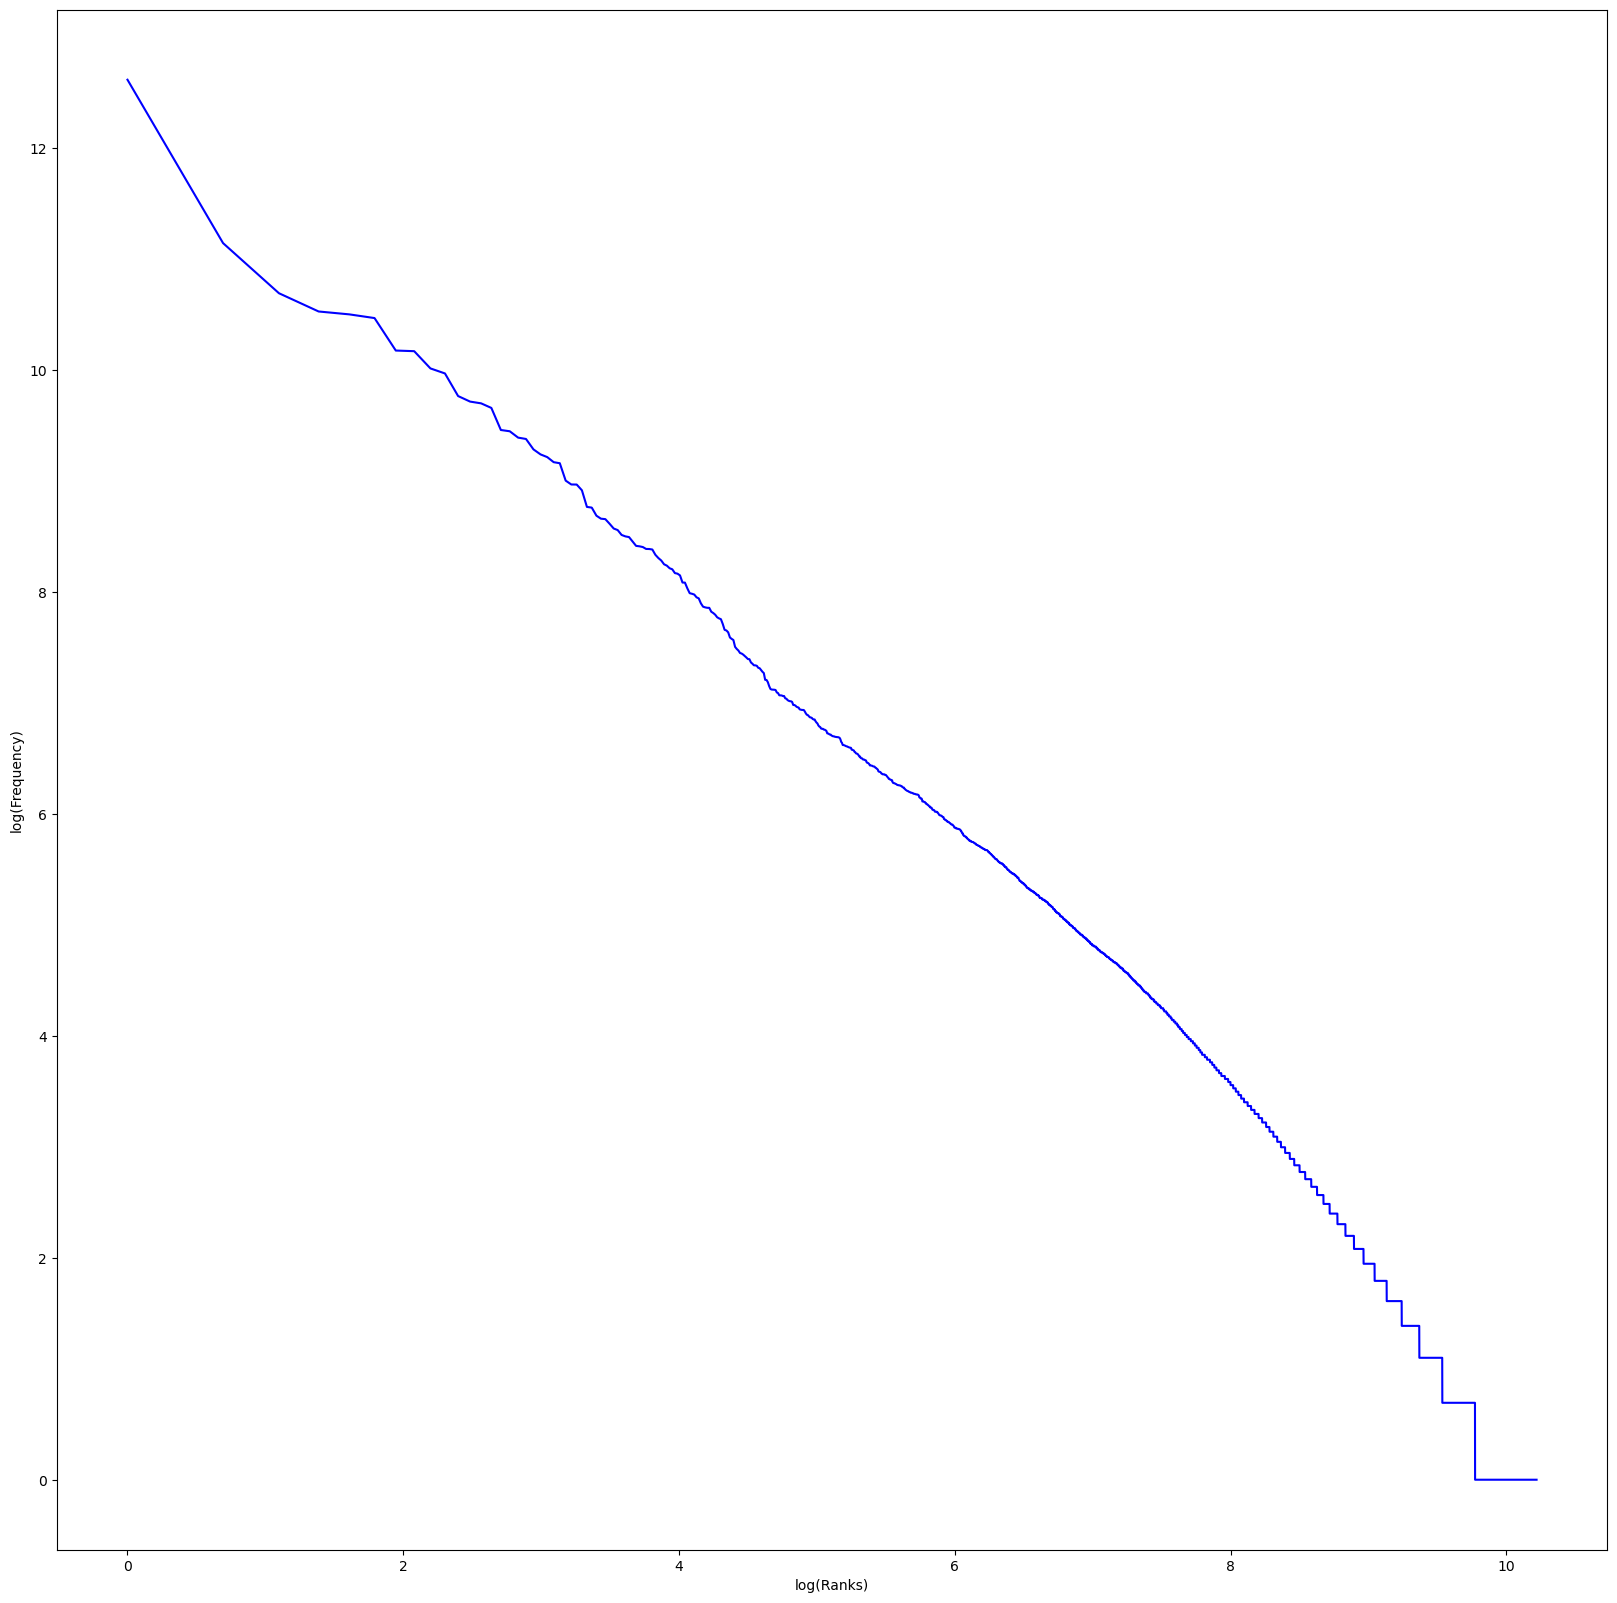

In [48]:
import operator as op

rank = 1
column_header = ['Rank', 'Frequency']

df_train = pd.DataFrame(columns = column_header)
collection_train = sorted(freq_train_.items(), key=op.itemgetter(1), reverse = True)

df_test = pd.DataFrame(columns = column_header)
collection_test = sorted(freq_test_.items(), key=op.itemgetter(1), reverse = True)

for w, f in collection_train:
    df_train.loc[w] = [rank, f]
    rank = rank + 1

for w, f in collection_test:
    df_test.loc[w] = [rank, f], rank*f
plt.plot(np.log(df_train.loc[:,'Rank']),np.log(df_train.loc[:,'Frequency']), 'b')

### 2.b) Bi-grammes

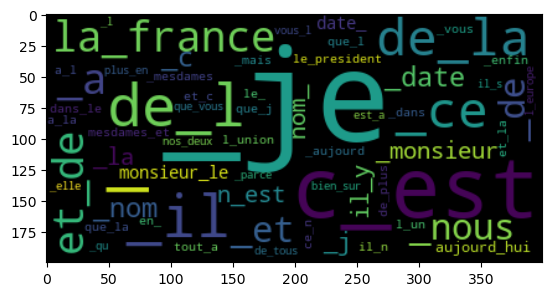

In [12]:
wc2 = Counter()
for text in x_train:
  x = text.rstrip().split(" ")
  wc2.update(set(zip(x[:-2],x[1:-1],x[2:])))

# 100 bigrammes les plus fréquents du train
freq_2 = [f for w,f in wc2.most_common()]
freq_2_100 = freq_2[:100]
bi_words = [w for w,f in wc2.most_common()]
bi_words_100 = bi_words[:100]

new_biwords = []
for words in bi_words_100:
  new_biwords.append(words[0]+'_'+words[1])

words = ' '.join([str(elem) for elem in new_biwords])
wordcloud = WordCloud().generate(words)

plt.imshow(wordcloud, interpolation='bilinear')

In [13]:
# vectorizer = CountVectorizer()
# X = vectorizer.fit_transform(x_train)
# words_freq = vectorizer.get_feature_names()
# dict_freq = {}
# for element in words_freq:
#     if element not in dict_freq:
#         dict_freq[element] = 1
#     else:
#         dict_freq[element] += 1

# freq_100 = []
# for i in range(100):
#     freq_100.append(sorted(dict_freq.items(), key=lambda t: t[1])[i][0])

# print(freq_100)

In [14]:
# vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
# X2 = vectorizer2.fit_transform(x_train)
# words2_freq = vectorizer2.get_feature_names()

### 2.c) Tri-grammes

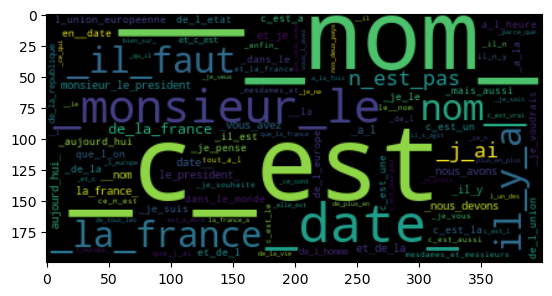

In [15]:
wc3 = Counter()
for text in x_train:
  x = text.rstrip().split(" ")
  wc3.update(set(zip(x[:-2],x[1:-1],x[2:])))

# 100 trigrammes les plus fréquents du train
freq_3 = [f for w,f in wc3.most_common()]
freq_3_100 = freq_3[:100]
tri_words = [w for w,f in wc3.most_common()]
tri_words_100 = tri_words[:100]

new_triwords = []
for words in tri_words_100:
  new_triwords.append(words[0]+'_'+words[1]+'_'+words[2])

words = ' '.join([str(elem) for elem in new_triwords])
wordcloud = WordCloud().generate(words)

plt.imshow(wordcloud, interpolation='bilinear')

## 3 - Equilibrage des données

Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des classes (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des classes?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.

1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.<BR>
   $\Rightarrow$ A vous de jouer pour cette technique
1. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$ 
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \text{si } y_i \in \text{classe majoritaire}\\
B>1 & \text{si } y_i \in \text{classe minoritaire}\\
\end{array} \right.$$
<BR>
   $\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.
1. Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.

**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.

In [16]:
print("Proportion de classe C: ", sum(np.array(y_train)==1)/len(y_train))
print("Proportion de classe M: ", sum(np.array(y_train)==-1)/len(y_train))

Proportion de classe C:  0.8689669587027329
Proportion de classe M:  0.13103304129726717


On remarque que la classe C est sur-représentée par rapport à la classe M.

In [17]:
#indice des phrases de Chirac dans le lot de training
idx_train_C = np.where((np.array(y_train)==1)==True)

y_train_C = []
x_train_C = []text
print(y_train_C[:10])
print(len(x_train_C))

[' quand je dis chers amis  il ne s agit pas la d une formule diplomatique  mais de l expression de ce que je ressens  ', ' d abord merci de cet exceptionnel accueil que les congolais  les brazavillois  nous ont reserve cet apres midi  ', ' c est toujours tres emouvant de venir en afrique car c est probablement l une des rares terres du monde ou l on ait conserve cette convivialite  cette amitie  ce respect de l autre qui s expriment avec chaleur  avec spontaneite et qui rechauffent le coeur de ceux qui arrivent et de ceux qui recoivent  ', ' aucun citoyen francais ne peut etre indifferent a un sejour a brazzaville  ', ' le congo  que naguere le  nom  qualifia de  refuge pour la liberte   de  base de depart pour la liberation   de  mole pour la resistance   comment ne pas etre heureux de s y retrouver   ', ' comment ne pas y voir un signe   ', ' brazzaville n est pas une capitale ordinaire  ', ' les voies de la libre disposition des peuples et de leur cooperation furent explorees il y 

In [18]:
#indice des phrases de Mitterand dans le lot de training
idx_train_M = np.where((np.array(y_train)==-1)==True)

y_train_M = []
x_train_M = []

for i in idx_train_M[0]:
    y_train_M.append(y_train[i])
    x_train_M.append(x_train[i])

In [46]:
#Suppression de données dans la classe majoritaire (Chirac)
x_new_train_C = []
y_new_train_C = []

list_idx = [i for i in range(len(x_train_C))]
list_aleatoire = rd.sample(list_idx,int(len(x_train_C)/2))

for i in list_aleatoire:
    x_new_train_C.append(x_train_C[i])
    y_new_train_C.append(y_train_C[i])
MultinomialNB()_new_train_C))

24945 24945


In [20]:
#Sur-échantillonnage dans la classe minoritaire (Mitterand)

x_new_train_M = x_train_M*3
y_new_train_M = y_train_M*3

print(len(x_new_train_M), len(y_new_train_M))

22569 22569


In [21]:
#On recrée un jeu de données de training avec la classe minoritaire
#sur-echantillonnée et la classe majoritaire rétrécie

x_new_train = x_new_train_C + x_new_train_M
y_new_train = y_new_train_C + y_new_train_M

print(len(x_new_train), len(y_new_train))

print("Nouvelle proportion de classe C: ", sum(np.array(y_new_train)==1)/len(y_new_train))
print("Nouvelle proportion de classe M: ", sum(np.array(y_new_train)==-1)/len(y_new_train))

47514 47514
Nouvelle proportion de classe C:  0.5250031569642631
Nouvelle proportion de classe M:  0.47499684303573686


Désormais, nous avons reformaté le dataset d'apprentissage en faisant deux modifications:

- Pre-processing: enlève les majuscules et la ponctuation (peut être amélioré en changeant le def preprocess)

- Équilibrage: le dataset d'apprentissage a été modifié de sorte que les deux classes soient à peu près autant représentées.

À partir de ce nouveau dataset d'apprentissage, nous allons construire deux nouveaux ensembles de données:

- Une partie apprentissage incluant:
    - une partie "fit" permettant d'apprendre à partir de certains modèles que nous allons définir dans la prochaine partie.

    - une partie "boost" permettant de booster les différents paramètres (hyperparamètres).

- Une partie test permettant de tester le modèle boosté sur de nouvelles données.


In [22]:
x_fit, x_boost, y_fit, y_boost = train_test_split(x_new_train, y_new_train, test_size = 0.33, random_state = 42)

print(len(x_fit), len(y_fit))
print(len(x_boost), len(y_boost))

31834 31834
15680 15680


# IV - Modèles de Machine Learning

Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:

- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?

## 1 - Construction des Tables

In [23]:
#Dataframe split
results_split = pd.DataFrame(columns=['NB', 'Temps_NB', 'LR', 'Temps_LR', 'SVM', 'Temps_SVM'], index=['PP classic', 'ngram=1', 'ngram=2', 'ngram=3', 'stopwords', 'max_features', 'max_def'])

#Dataframe Cross-validation
results_cv = pd.DataFrame(columns=['NB', 'Temps_NB', 'LR', 'Temps_LR', 'SVM', 'Temps_SVM'], index=['PP classic', 'ngram=1', 'ngram=2', 'ngram=3', 'stopwords', 'max_features', 'max_def'])

## 2 - Application de différents modèles
### 2.a) Pre-processing classique
#### Avec split

In [24]:
vectorizer = CountVectorizer()

x_train_pp_split = vectorizer.fit_transform(x_fit) 
x_test_pp_split = vectorizer.transform(x_boost)

#Naïve Bayes
start_nb = time.time()
mod_nb = MultinomialNB()
mod_nb.fit(x_train_pp_split, y_fit)
end_nb = time.time()
results_split.loc['PP classic', 'NB'] = mod_nb.score(x_test_pp_split, y_boost)
results_split.loc['PP classic', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
mod_lr = LogisticRegression(random_state=0, C=1e-3)
mod_lr.fit(x_train_pp_split, y_fit)
end_lr = time.time()
results_split.loc['PP classic', 'LR'] = mod_lr.score(x_test_pp_split, y_boost)
results_split.loc['PP classic', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
mod_svm = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
mod_svm.fit(x_train_pp_split, y_fit)
end_svm = time.time()
results_split.loc['PP classic', 'SVM'] = mod_svm.score(x_test_pp_split, y_boost)
results_split.loc['PP classic', 'Temps_SVM'] = end_svm - start_svm

#### Avec validation croisée

In [25]:
x_train_pp_cv = vectorizer.fit_transform(x_new_train)

#Naïve Bayes
start_nb = time.time()
mod_nb_cv = cross_val_score(mod_nb, x_train_pp_cv, y_new_train, cv=5, scoring='accuracy')
end_nb = time.time()
results_cv.loc['PP classic', 'NB'] = mod_nb_cv.mean()
results_cv.loc['PP classic', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
mod_lr_cv = cross_val_score(mod_lr, x_train_pp_cv, y_new_train, cv=5, scoring='accuracy')
end_lr = time.time()
results_cv.loc['PP classic', 'LR'] = mod_lr_cv.mean()
results_cv.loc['PP classic', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
mod_svm_cv = cross_val_score(mod_svm, x_train_pp_cv, y_new_train, cv=5, scoring='accuracy')
end_svm = time.time()
results_cv.loc['PP classic', 'SVM'] = mod_svm_cv.mean()
results_cv.loc['PP classic', 'Temps_SVM'] = end_svm - start_svm

### 2.b) Avec ngrams (1, 2 et 3)

Les ngrams permettent d'intégrer aux modèles les mots seuls, ainsi que les doublets de mots, les triplets etc... jusqu'aux groupes de n-mots. Nous allons nous limiter aux 3-grams, comptabilisant les mots seuls, les doublets de mots et les triplets.

Comme précédemment avec le pré-processing classique, nous allons faire avec et sans validation croisée pour chaque valeur de n-gram.

In [26]:
vectorizer_ngram1 = CountVectorizer(ngram_range=(1,1))

x_train_ng1_split = vectorizer_ngram1.fit_transform(x_fit) 
x_test_ng1_split = vectorizer_ngram1.transform(x_boost)

#Naïve Bayes
start_nb = time.time()
mod_nb = MultinomialNB()
mod_nb.fit(x_train_ng1_split, y_fit)
end_nb = time.time()
results_split.loc['ngram=1', 'NB'] = mod_nb.score(x_test_ng1_split, y_boost)
results_split.loc['ngram=1', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = timLogisticRegressionloc['ngram=1', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
mod_svm = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
mod_svm.fit(x_train_ng1_split, y_fit)
end_svm = time.time()
results_split.loc['ngram=1', 'SVM'] = mod_svm.score(x_test_ng1_split, y_boost)
results_split.loc['ngram=1', 'Temps_SVM'] = end_svm - start_svm

In [27]:
x_train_ng1_cv = vectorizer_ngram1.fit_transform(x_new_train)

#Naïve Bayes
start_nb = time.time()
mod_nb_cv = cross_val_score(mod_nb, x_train_ng1_cv, y_new_train, cv=5, scoring='accuracy')
end_nb = time.time()
results_cv.loc['ngram=1', 'NB'] = mod_nb_cv.mean()
results_cv.loc['ngram=1', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
mod_lr_cv = cross_val_score(mod_lr, x_train_ng1_cv, y_new_train, cv=5, scoring='accuracy')
end_lr = time.time()
results_cv.loc['ngram=1', 'LR'] = mod_lr_cv.mean()
results_cv.loc['ngram=1', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
mod_svm_cv = cross_val_score(mod_svm, x_train_ng1_cv, y_new_train, cv=5, scoring='accuracy')
end_svm = time.time()
results_cv.loc['ngram=1', 'SVM'] = mod_svm_cv.mean()
results_cv.loc['ngram=1', 'Temps_SVM'] = end_svm - start_svm

In [28]:
MultinomialNB()

In [29]:
x_train_ng2_cv = vectorizer_ngram2.fit_transform(x_new_train)

#Naïve Bayes
start_nb = time.time()
mod_nb_cv = cross_val_score(mod_nb, x_train_ng2_cv, y_new_train, cv=5, scoring='accuracy')
end_nb = time.time()
results_cv.loc['ngram=2', 'NB'] = mod_nb_cv.mean()
results_cv.loc['ngram=2', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
mod_lr_cv = cross_val_score(mod_lr, x_train_ng2_cv, y_new_train, cv=5, scoring='accuracy')
end_lr = time.time()
results_cv.loc['ngram=2', 'LR'] = mod_lr_cv.mean()
results_cv.loc['ngram=2', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
mod_svm_cv = cross_val_score(mod_svm, x_train_ng2_cv, y_new_train, cv=5, scoring='accuracy')
end_svm = time.time()
results_cv.loc['ngram=2', 'SVM'] = mod_svm_cv.mean()
results_cv.loc['ngram=2', 'Temps_SVM'] = end_svm - start_svm

In [30]:
vectorizer_ngram3 = CountVectorizer(ngram_range=(1,3))

x_train_ng3_split = vectorizer_ngram3.fit_transform(x_fit) 
x_test_ng3_split = vectorizer_ngram3.transform(x_boost)

#Naïve Bayes
start_nb = time.time()
mod_nb = MultinomialNB()
mod_nb.fit(x_train_ng3_split, y_fit)
end_nb = time.time()
results_split.loc['ngram=3', 'NB'] = mod_nb.score(x_test_ng3_split, y_boost)
results_split.loc['ngram=3', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
mod_lr = LogisticRegression(random_state=0, C=1e-3)
mod_lr.fit(x_train_ng3_split, y_fit)
end_lr = time.time()
results_split.loc['ngram=3', 'LR'] = mod_lr.score(x_test_ng3_split, y_boost)
results_split.loc['ngram=3', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
mod_svm = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
mod_svm.fit(x_train_ng3_split, y_fit)
end_svm = time.time()
results_split.loc['ngram=3', 'SVM'] = mod_svm.score(x_test_ng3_split, y_boost)
results_split.loc['ngram=3', 'Temps_SVM'] = end_svm - start_svm

In [31]:
x_train_ng3_cv = vectorizer_ngram3.fit_transform(x_new_train)

#Naïve Bayes
start_nb = time.time()
mod_nb_cv = cross_val_score(mod_nb, x_train_ng3_cv, y_new_train, cv=5, scoring='accuracy')
end_nb = time.time()
results_cv.loc['ngram=3', 'NB'] = mod_nb_cv.mean()
results_cv.loc['ngram=3', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression
start_lr = time.time()
mod_lr_cv = cross_val_score(mod_lr, x_train_ng3_cv, y_new_train, cv=5, scoring='accuracy')
end_lr = time.time()
results_cv.loc['ngram=3', 'LR'] = mod_lr_cv.mean()
results_cv.loc['ngram=3', 'Temps_LR'] = end_lr - start_lr

#Linear SVM
start_svm = time.time()
mod_svm_cv = cross_val_score(mod_svm, x_train_ng3_cv, y_new_train, cv=5, scoring='accuracy')
end_svm = time.time()
results_cv.loc['ngram=3', 'SVM'] = mod_svm_cv.mean()
results_cv.loc['ngram=3', 'Temps_SVM'] = end_svm - start_svm

In [32]:
results_split

,NB,Temps_NB,LR,Temps_LR,SVM,Temps_SVM
PP classic,0.831696,0.006646,0.700829,0.123093,0.757589,0.099509
ngram=1,0.831696,0.006521,0.700829,0.113897,0.757589,0.097073
ngram=2,0.880357,0.012589,0.715944,0.861442,0.790115,0.236233
ngram=3,0.895472,0.029075,0.722258,2.078637,0.807972,0.404136
stopwords,NaN,NaN,NaN,NaN,NaN,NaN
max_features,NaN,NaN,NaN,NaN,NaN,NaN
max_def,NaN,NaN,NaN,NaN,NaN,NaN
boost,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
results_cv

,NB,Temps_NB,LR,Temps_LR,SVM,Temps_SVM
PP classic,0.841268,0.091108,0.706928,1.05152,0.766721,0.797887
ngram=1,0.841268,0.070061,0.706928,1.032744,0.766721,0.795062
ngram=2,0.909858,0.134822,0.723555,5.259964,0.805468,1.76889
ngram=3,0.930357,0.265013,0.730774,13.908264,0.829019,3.216562
stopwords,NaN,NaN,NaN,NaN,NaN,NaN
max_features,NaN,NaN,NaN,NaN,NaN,NaN
max_def,NaN,NaN,NaN,NaN,NaN,NaN
boost,NaN,NaN,NaN,NaN,NaN,NaN


Avec ngram = 3, l'apprentissage semble avoir mieux fonctionné qu'avec les autres méthodes, et la validation croisée semble nécessaire afin de booster les performances.

### 2.c) Amélioration du modèle

#### Stopwords

Afin d'améliorer le précédent modèle, nous allons essayer d'enlever les stopwords, c'est-à-dire les mots très fréquents comme "de", "le", "la" etc... qui peuvent s'avérer inutiles à la classification voire qui peuvent fausser les résultats. Mais ces mots peuvent au contraire être nécessaire. C'est ce que nous allons désormais tester.

Concernant les accents, il semble qu'ils n'aient pas une grande importance dans l'apprentissage. Nous avons décidé de ne pas faire de test là-dessus.

In [34]:
wc = Counter()
for text in x_fit:
    wc.update(text.split(" "))
    
stopwords = [w for w,f in wc.most_common(100)]

liste_sw = []
perf_nb_sw = []
perf_lr_sw = []
perf_svm_sw = []

In [35]:
for sw in range(0,110,10):
    liste_sw.append(sw)
    stopwords_sw = stopwords[0:sw]

    vectorizer = CountVectorizer(stop_words=stopwords_sw, ngram_range=(1,3), analyzer='word')
    x_train_sw = vectorizer.fit_transform(x_fit) 
    x_test_sw = vectorizer.transform(x_boost)

    #Naïve Bayes
    mod_nb = MultinomialNB()
    mod_nb.fit(x_train_sw, y_fit)
    perf_nb_sw.append(mod_nb.score(x_test_sw, y_boost))

    #Logistic Regression
    mod_lr = LogisticRegression(random_state=0, C=1e-3)
    mod_lr.fit(x_train_sw, y_fit)
    perf_lr_sw.append(mod_lr.score(x_test_sw, y_boost))

    #Linear SVM
    mod_svm = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
    mod_svm.fit(x_train_sw, y_fit)
    perf_svm_sw.append(mod_svm.score(x_test_sw, y_boost))

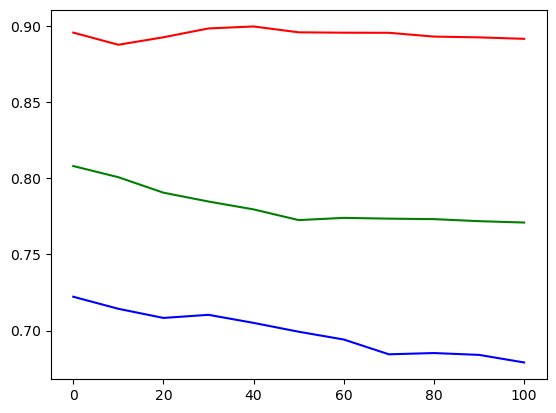

In [36]:
plt.plot(liste_sw, perf_nb_sw, 'r',)
plt.plot(liste_sw, perf_lr_sw, 'b')
plt.plot(liste_sw, perf_svm_sw, 'g')
plt.show()

Enlever les stopwords ne s'avère pas si utile. Au contraire, la performance semble baisser dans tous les cas. 

In [37]:
results_split = results_split.drop('stopwords')
results_cv = results_cv.drop('stopwords')

#### Max_features

Cependant, une autre technique pour enlever des mots est le contrôle du paramètre max_features. Si max_features est défini sur None, l'ensemble du corpus est pris en compte lors de la transformation TF-IDF. En ajoutant une valeur à max_features, alors le nombre de mots dans le vocabulaire sera limité à cette valeur. Ainsi, pour d documents et 100 mots, si on met un max_feature à 80, alors la sparse matrix aura comme dimension 3x80 au lieu de 3x100.

In [38]:
liste_feat = []
perf_nb_feat = []
perf_lr_feat = []
perf_svm_feat = []

for feat in range(100,60000,500):
    liste_feat.append(feat)

    vectorizer = CountVectorizer(ngram_range=(1,3), max_features=feat)
    x_train_feat = vectorizer.fit_transform(x_fit) 
    x_test_feat = vectorizer.transform(x_boost)

    #Naïve Bayes
    mod_nb = MultinomialNB()
    mod_nb.fit(x_train_feat, y_fit)
    perf_nb_feat.append(mod_nb.score(x_test_feat, y_boost))

    #Logistic Regression
    mod_lr = LogisticRegression(random_state=0, C=1e-3)
    mod_lr.fit(x_train_feat, y_fit)
    perf_lr_feat.append(mod_lr.score(x_test_feat, y_boost))

    #Linear SVM
    mod_svm = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
    mod_svm.fit(x_train_feat, y_fit)
    perf_svm_feat.append(mod_svm.score(x_test_feat, y_boost))

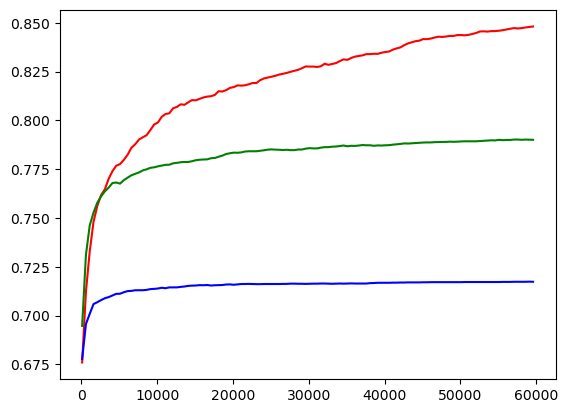

In [39]:
plt.plot(liste_feat, perf_nb_feat, 'r')
plt.plot(liste_feat, perf_lr_feat, 'b')
plt.plot(liste_feat, perf_svm_feat, 'g')
plt.show()

On remarque que plus il y a de mots dans le vocabulaire, plus l'apprentissage est performant et ce indépendemment du modèle. Ainsi, nous en concluons que l'outil max_feature n'a pas besoin d'être réglé, et que nous pouvons nous intéresser au vocabulaire dans son intégralité.

In [40]:
results_split = results_split.drop('max_features')
results_cv = results_cv.drop('max_features')

#### Max_def

Les stopwords sont les mots qui apparaissent très fréquemment dans l'ensemble du corpus. On peut également éliminer, grâce à la variable max_df, les mots qui apparaissent dans beaucoup de documents différents. Un mot peut ne pas être très fréquent dans l'ensemble mais apparaître dans chaque document et ainsi ne pas être utile à la classification.

In [41]:
liste_df = []
perf_nb_df = []
perf_lr_df = []
perf_svm_df = []

for df in range(1,51000,1000):
    liste_df.append(df)

    vectorizer = CountVectorizer(ngram_range=(1,3), max_df=df)
    x_train_df = vectorizer.fit_transform(x_fit) 
    x_test_df = vectorizer.transform(x_boost)

    #Naïve Bayes
    mod_nb = MultinomialNB()
    mod_nb.fit(x_train_df, y_fit)
    perf_nb_df.append(mod_nb.score(x_test_df, y_boost))

    #Logistic Regression
    mod_lr = LogisticRegression(random_state=0, C=1e-3)
    mod_lr.fit(x_train_df, y_fit)
    perf_lr_df.append(mod_lr.score(x_test_df, y_boost))

    #Linear SVM
    mod_svm = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
    mod_svm.fit(x_train_df, y_fit)
    perf_svm_df.append(mod_svm.score(x_test_df, y_boost))

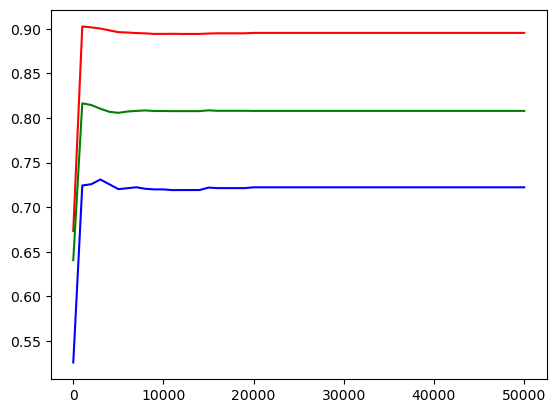

In [42]:
plt.plot(liste_df, perf_nb_df, 'r')
plt.plot(liste_df, perf_lr_df, 'b')
plt.plot(liste_df, perf_svm_df, 'g')
plt.show()

Il semble y avoir une valeur de max_df permettant de maximiser la performance. Nous allons donc l'ajouter au modèle.

In [43]:
#Naïve Bayes

vectorizer_nb_df = CountVectorizer(ngram_range=(1,3), min_df=1, max_df=liste_df[np.argmax(perf_nb_df)])

x_train_nb_df = vectorizer_nb_df.fit_transform(x_fit) 
x_test_nb_df = vectorizer_nb_df.transform(x_boost)

start_nb = time.time()
mod_nb = MultinomialNB()
mod_nb.fit(x_train_nb_df, y_fit)
end_nb = time.time()
results_split.loc['max_def', 'NB'] = mod_nb.score(x_test_nb_df, y_boost)
results_split.loc['max_def', 'Temps_NB'] = end_nb - start_nb

x_nb_df_cv = vectorizer_nb_df.fit_transform(x_new_train)
start_nb = time.time()
mod_nb_cv = cross_val_score(mod_nb, x_nb_df_cv, y_new_train, cv=5, scoring='accuracy')
end_nb = time.time()
results_cv.loc['max_def', 'NB'] = mod_nb_cv.mean()
results_cv.loc['max_def', 'Temps_NB'] = end_nb - start_nb

#Logistic Regression

vectorizer_lr_df = CountVectorizer(ngram_range=(1,3), min_df=1, max_df=liste_df[np.argmax(perf_lr_df)])

x_train_lr_df = vectorizer_lr_df.fit_transform(x_fit) 
x_test_lr_df = vectorizer_lr_df.transform(x_boost)

start_lr = time.time()
mod_lr = LogisticRegression(random_state=0, C=1e-3)
mod_lr.fit(x_train_lr_df, y_fit)
end_lr = time.time()
results_split.loc['max_def', 'LR'] = mod_lr.score(x_test_lr_df, y_boost)
results_split.loc['max_def', 'Temps_LR'] = end_lr - start_lr

x_lr_df_cv = vectorizer_lr_df.fit_transform(x_new_train)
start_lr = time.time()
mod_lr_cv = cross_val_score(mod_lr, x_lr_df_cv, y_new_train, cv=5, scoring='accuracy')
end_lr = time.time()
results_cv.loc['max_def', 'LR'] = mod_lr_cv.mean()
results_cv.loc['max_def', 'Temps_LR'] = end_nb - start_nb

#Linear SVM

vectorizer_svm_df = CountVectorizer(ngram_range=(1,3), min_df=1, max_df=liste_df[np.argmax(perf_svm_df)])

x_train_svm_df = vectorizer_svm_df.fit_transform(x_fit) 
x_test_svm_df = vectorizer_svm_df.transform(x_boost)

start_svm = time.time()
mod_svm = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
mod_svm.fit(x_train_svm_df, y_fit)
end_svm = time.time()
results_split.loc['max_def', 'SVM'] = mod_svm.score(x_test_svm_df, y_boost)
results_split.loc['max_def', 'Temps_SVM'] = end_svm - start_svm

x_svm_df_cv = vectorizer_svm_df.fit_transform(x_new_train)
start_svm = time.time()
mod_svm_cv = cross_val_score(mod_svm, x_svm_df_cv, y_new_train, cv=5, scoring='accuracy')
end_svm = time.time()
results_cv.loc['max_def', 'SVM'] = mod_svm_cv.mean()
results_cv.loc['max_def', 'Temps_SVM'] = end_svm - start_svm

In [44]:
results_split

,NB,Temps_NB,LR,Temps_LR,SVM,Temps_SVM
PP classic,0.831696,0.006646,0.700829,0.123093,0.757589,0.099509
ngram=1,0.831696,0.006521,0.700829,0.113897,0.757589,0.097073
ngram=2,0.880357,0.012589,0.715944,0.861442,0.790115,0.236233
ngram=3,0.895472,0.029075,0.722258,2.078637,0.807972,0.404136
max_def,0.902679,0.025615,0.730995,1.647782,0.816454,0.328946
boost,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
results_cv

,NB,Temps_NB,LR,Temps_LR,SVM,Temps_SVM
PP classic,0.841268,0.091108,0.706928,1.05152,0.766721,0.797887
ngram=1,0.841268,0.070061,0.706928,1.032744,0.766721,0.795062
ngram=2,0.909858,0.134822,0.723555,5.259964,0.805468,1.76889
ngram=3,0.930357,0.265013,0.730774,13.908264,0.829019,3.216562
max_def,0.936629,0.267715,0.743739,0.267715,0.847077,1.845136
boost,NaN,NaN,NaN,NaN,NaN,NaN


# V - Test du modèle sur les données test

In [47]:
# Naive bayes

vectorizer_nb_df.fit(x_fit)
x_train_nb = vectorizer_nb_df.fit_transform(x_fit)
x_test_nb = vectorizer_nb_df.transform(x_test)

mod_nb = MultinomialNB()
mod_nb.fit(x_train_nb, y_fit)

print(mod_nb.score(x_test_nb, y_test))
pred_nb = mod_nb.predict(x_test_nb)

# Logistic Regression

vectorizer_lr_df.fit(x_fit)
x_train_lr = vectorizer_lr_df.fit_transform(x_fit)
x_test_lr = vectorizer_lr_df.transform(x_test)

mod_lr = LogisticRegression(random_state=0, C=1e-3)
mod_lr.fit(x_train_lr, y_fit)

print(mod_lr.score(x_test_lr, y_test))
pred_lr = mod_lr.predict(x_test_lr)

#SVM

vectorizer_svm_df.fit(x_fit)
x_train_svm = vectorizer_svm_df.fit_transform(x_fit)
x_test_svm = vectorizer_svm_df.transform(x_test)

mod_svm = LinearSVC(random_state=0, tol=1e-5, C=1e-3)
mod_svm.fit(x_train_svm, y_fit)

print(mod_svm.score(x_test_svm, y_test))
pred_svm = mod_svm.predict(x_test_svm)

0.6970767984684486
0.7777041454973861
0.7701200206170385


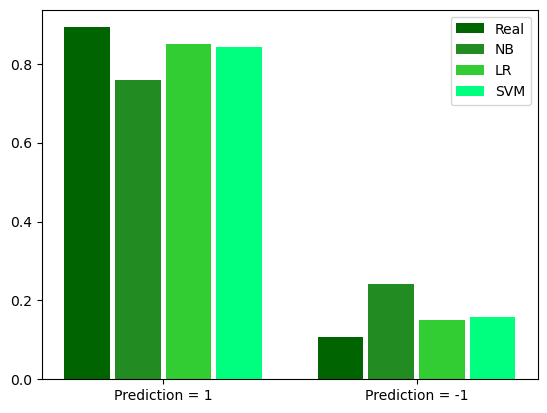

In [49]:
barwidth = 0.9

plt.bar(x=[1], width=barwidth, height=sum(np.array(y_test)==1)/len(y_test), color='darkgreen', label='Real')
plt.bar(x=[2], width=barwidth, height=sum(pred_nb==1)/len(pred_nb), color='forestgreen', label='NB')
plt.bar(x=[3], width=barwidth, height=sum(pred_lr==1)/len(pred_nb), color='limegreen', label='LR')
plt.bar(x=[4], width=barwidth, height=sum(pred_svm==1)/len(pred_nb), color='springgreen', label='SVM')

plt.bar(x=[6], width=barwidth, height=sum(np.array(y_test)!=1)/len(y_test), color='darkgreen')
plt.bar(x=[7], width=barwidth, height=sum(pred_nb!=1)/len(pred_nb), color='forestgreen')
plt.bar(x=[8], width=barwidth, height=sum(pred_lr!=1)/len(pred_nb), color='limegreen')
plt.bar(x=[9], width=barwidth, height=sum(pred_svm!=1)/len(pred_nb), color='springgreen')

plt.xticks([r for r in [2.5, 7.5]], ['Prediction = 1', 'Prediction = -1'])

plt.legend()

Text(0.5, 1.0, 'Evolution de la performance (accuracy) avec le prétraitement selon les modèles')

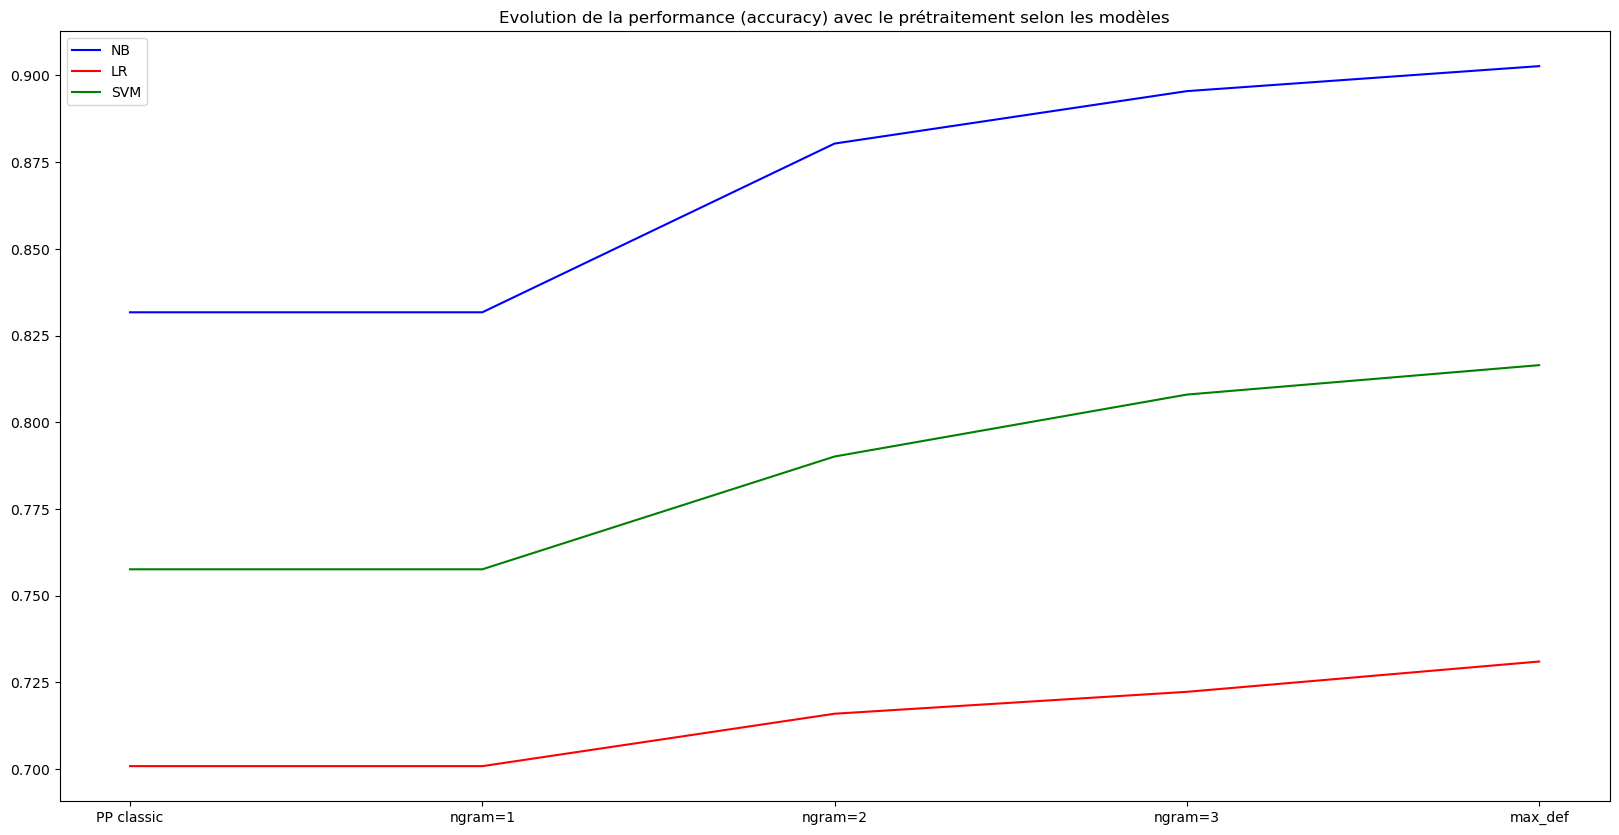

In [50]:
plt.figure(figsize=(20,10))
plt.plot(results_split['NB'], 'b')
plt.plot(results_split['LR'], 'r')
plt.plot(results_split['SVM'], 'g')
plt.legend(['NB', 'LR', 'SVM'])
plt.title('Evolution de la performance (accuracy) avec le prétraitement selon les modèles')

Text(0.5, 1.0, 'Evolution de la performance (accuracy) avec le prétraitement selon les modèles')

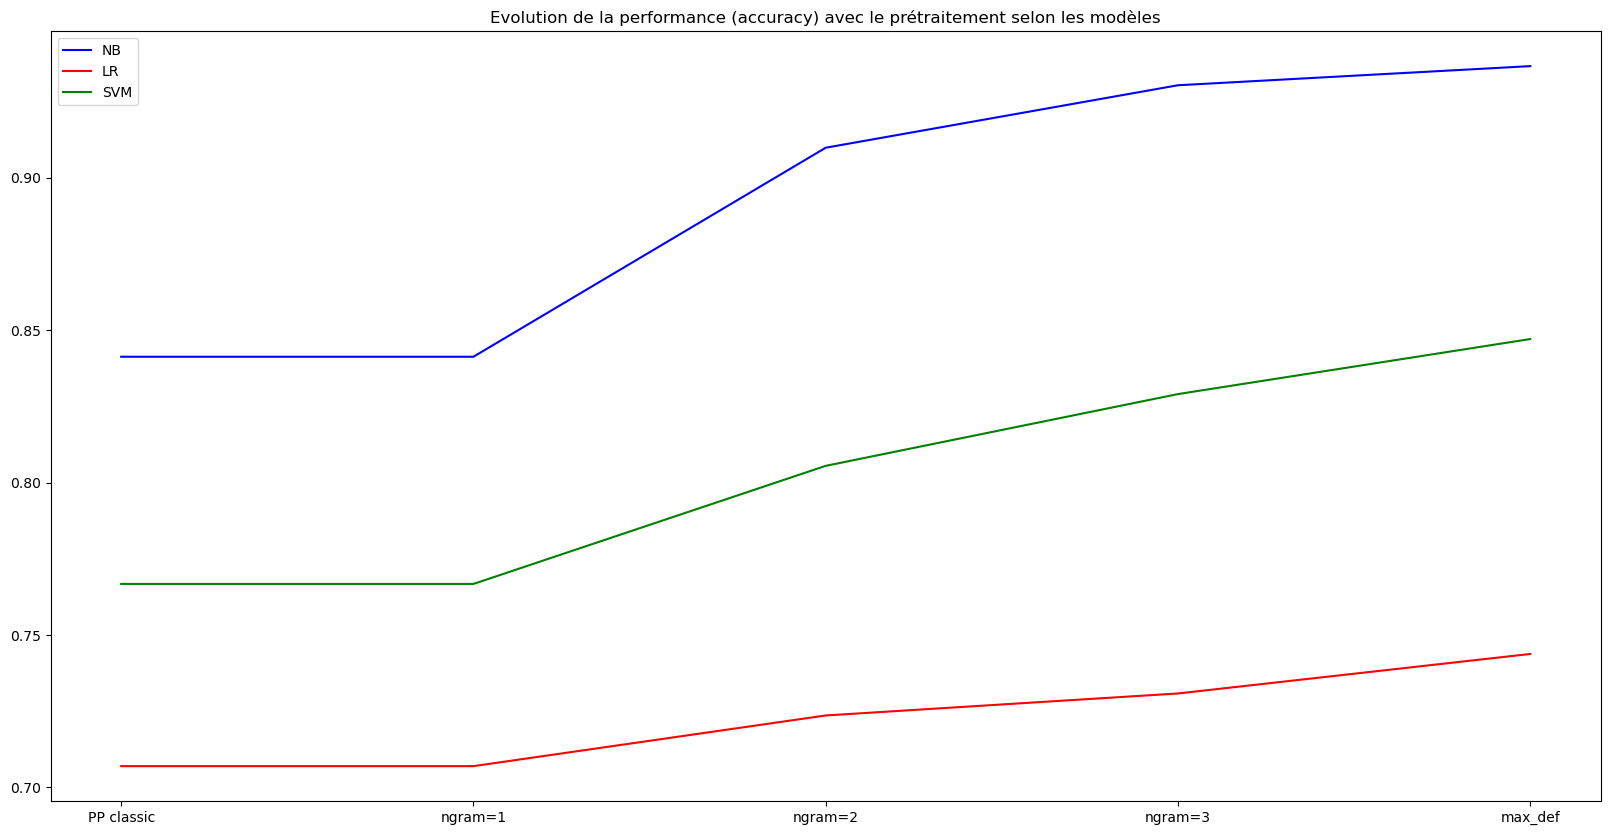

In [51]:
plt.figure(figsize=(20,10))
plt.plot(results_cv['NB'], 'b')
plt.plot(results_cv['LR'], 'r')
plt.plot(results_cv['SVM'], 'g')
plt.legend(['NB', 'LR', 'SVM'])
plt.title('Evolution de la performance (accuracy) avec le prétraitement selon les modèles')